# MIRI DATA: LUHMAN 16 B
## MIRI Slitless/PRISM: Luhman 16 Stage 3 Data Reading and Plotting

## 1. Inititilization

In [115]:
import numpy as np
import astropy 
import astropy.io.fits as fits
import matplotlib.pyplot as plt
import matplotlib
import warnings

import os
import time
from tqdm import tqdm
import pandas as pd
from collections import defaultdict
from sklearn.linear_model import LinearRegression
from PyAstronomy.pyTiming import pyPeriod

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

filename = '~/Documents/jwst_Luh16_2024/MAST_2024-11-14T1352/JWST/jw02965-o001_t001_miri_p750l-slitlessprism/jw02965-o001_t001_miri_p750l-slitlessprism_x1dints.fits'
dataOutputFolder = '/Users/nguyendat/Documents/jwst_Luh16_2024/myNotebooks/output/'

def printtime(t0, t1):
    print(f"Execution time: dd hh:mm:ss.ss", pd.Timedelta(seconds=t1-t0))

import os
os.environ["MKL_SERVICE_FORCE_INTEL"] = "1"

### 1b. Explore and print fits metadata.
Note that data structure of stage 3 JWST NIRSPEC and MIRI data is standardized, following this: 
+ INT_TIMES: integration time stamps (Dimension #T, typically large)
    + Contains tens of columns of integration start, midpoint and ends. N1 x #T
+ EXTRACT1D: Spectra at each respective timestamp
    + Typically tens of columns (Dimension N2) following each wavelength (Dimension #L)

The total data will be N1 x #T x N2 x #L: Can be very large!

In [116]:
with fits.open(filename) as hdul:
    # Access the integration time header
    intTime_header = hdul[1].columns.names
    extract1d_hdu = hdul['EXTRACT1D']  # Adjust index or name as needed
    hdu_len = len(hdul)
    
    print('Length of fits: %s HDUs'%hdu_len)
    print("INT_TIMES Columns: ", intTime_header)
    print("EXTRACT1D Columns:", extract1d_hdu.columns.names)
    print("EXTRACT1D Data shape:", extract1d_hdu.data.shape)
    print("EXTRACT1D First row sample:", extract1d_hdu.data[0])

Length of fits: 2196 HDUs
INT_TIMES Columns:  ['integration_number', 'int_start_MJD_UTC', 'int_mid_MJD_UTC', 'int_end_MJD_UTC', 'int_start_BJD_TDB', 'int_mid_BJD_TDB', 'int_end_BJD_TDB']
EXTRACT1D Columns: ['WAVELENGTH', 'FLUX', 'FLUX_ERROR', 'FLUX_VAR_POISSON', 'FLUX_VAR_RNOISE', 'FLUX_VAR_FLAT', 'SURF_BRIGHT', 'SB_ERROR', 'SB_VAR_POISSON', 'SB_VAR_RNOISE', 'SB_VAR_FLAT', 'DQ', 'BACKGROUND', 'BKGD_ERROR', 'BKGD_VAR_POISSON', 'BKGD_VAR_RNOISE', 'BKGD_VAR_FLAT', 'NPIXELS']
EXTRACT1D Data shape: (388,)
EXTRACT1D First row sample: (14.047499656677246, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)


### 1c. Read the fits file and extract necessary data to DataFrame. 
This MIRI dataset is light so I skipped writing the DataFrame to hdf5. 
Export the DataFrame saves a lot of runtimes because some .fits take very long to read (i.e NIRSPEC data of bright stars with lots of integration to not saturate the detector.)

In [117]:
# Open the FITS file
start_time = time.time() 
with fits.open(filename, memmap=True) as hdul:
    # Extract time information from INT_TIMES
    
    time_data = hdul['INT_TIMES'].data
    int_times = time_data['int_mid_BJD_TDB']  # Directly access the column by name
    int_times_hour = (int_times - int_times[0]) * 24
    
    # Prepare a DataFrame for the results:
    spectra_data = {'Time_BJDmid': int_times, 'Time_hour': int_times_hour}
    
    # Initialize lists for flux, flux error, and wavelength
    flux, fluxerr = [], []
    wavelength = None

    # Iterate over HDUs once and extract the necessary data
    for i, hdu in tqdm(enumerate(hdul[1:]), total=hdu_len - 1, desc="Processing HDUs"):
        if 'EXTRACT1D' in hdu.name:
            # Append FLUX and FLUX_ERROR
            flux.append(hdu.data['FLUX'][5:-7])
            fluxerr.append(hdu.data['FLUX_ERROR'][5:-7])
            if wavelength is None:  # Extract wavelength only once
                wavelength = hdu.data['WAVELENGTH'][5:-7]

    # Combine the data
    spectra_data.update({'Flux': flux, 'Flux_Error': fluxerr})

# Create DataFrame
spectra_df_raw = pd.DataFrame(spectra_data)

end_time = time.time()
print(f"Execution time: {end_time-start_time:.2f} seconds")

Processing HDUs: 100%|█████████████████████████████████████████████████████████| 2195/2195 [00:08<00:00, 270.31it/s]


Execution time: 8.72 seconds


### 1d. Let's plot a set of 20 spectra at the start, and at the middle of observation.

The spectra at the start of the observation set seems wonky, probably due to ramps.

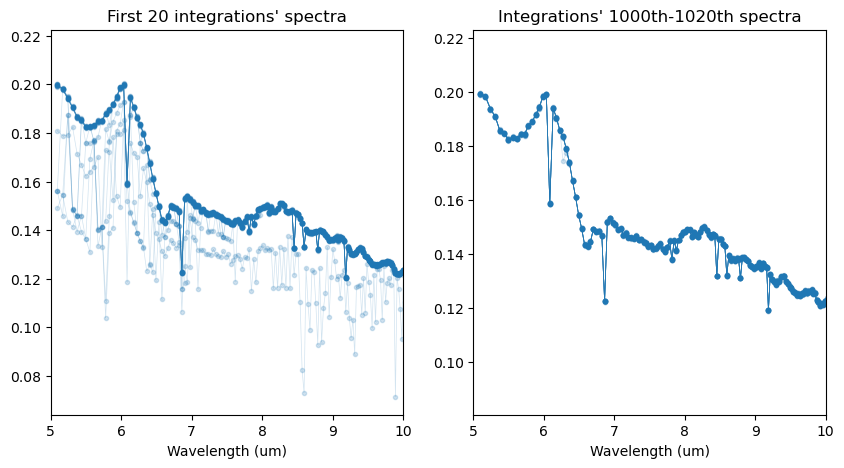

In [119]:
plt.close('all')
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 5))
for i in np.arange(0,20):
    ax1.errorbar(x=wavelength, y=spectra_df_raw.Flux[i], yerr=spectra_df_raw.Flux_Error[i], 
            ls='-', lw=0.5, marker='.', alpha=0.2, c='tab:blue')
ax1.set_xlim(5,10)
ax1.set_xlabel('Wavelength (um)')
ax1.set_title('First 20 integrations\' spectra')

for i in np.arange(1000,1020):
    ax2.errorbar(x=wavelength, y=spectra_df_raw.Flux[i], yerr=spectra_df_raw.Flux_Error[i], 
            ls='-', lw=0.5, marker='.', alpha=0.2, c='tab:blue')
ax2.set_xlim(5,10)
ax2.set_xlabel('Wavelength (um)')
ax2.set_title('Integrations\' 1000th-1020th spectra')

plt.show()

### 1e. Now let's plot the wavelength-averaged (MIRI Slitless PRISM so 5-14um) light curve.

Two things:

1. There's a dip at start of the light curve, might be related to spectra ramp above?
2. There seems to be a linear trend downward in the wavelength-averaged light curve (and extracting by wavelength bins this trend still persist). 

For 1, I removed the first twenty integration.

And for 2, I can remove the trend (flattening) by linear regress the light curve and then subtract that trend.

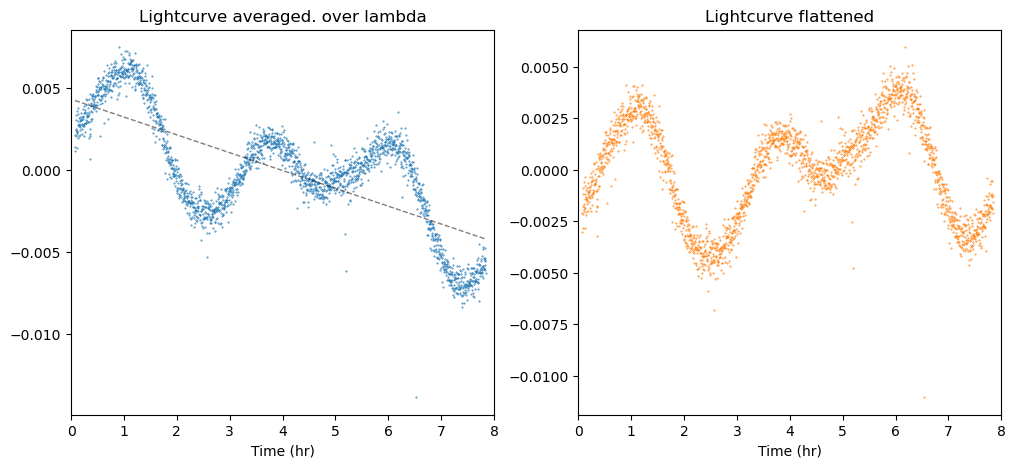

Slope, intercept: -0.001084412907532701 0.0042916513989852785


In [120]:
# plot wavelength-avg flux

# First let's drop the first 20 integrations (<1% of data).
plot_df = spectra_df_raw.iloc[20:].dropna()

mean_flux = []
for spec in plot_df.Flux:
    mean_flux.append(spec.mean())
# print(len(mean_flux))
mean_flux = pd.Series(mean_flux)
mean_flux = (mean_flux - mean_flux.mean())/mean_flux.mean()

%matplotlib inline
plt.close()
fig, (ax, ax2) = plt.subplots(1,2, figsize=(12,5))

timearray = plot_df.Time_hour

# linear regression of light curve
modelLinReg_timeavg = LinearRegression()
X = timearray.to_numpy().reshape(-1, 1)
modelLinReg_timeavg.fit(X, mean_flux)
linreg = modelLinReg_timeavg.predict(X)
# ax+b
linreg_b = modelLinReg_timeavg.intercept_ 
linreg_a = modelLinReg_timeavg.coef_[0]

ax.plot(timearray, mean_flux, ls='', marker='.', ms=0.8)
ax.plot(timearray, linreg, color='k', alpha=0.5, lw=1, ls='--')
ax.set_xlabel('Time (hr)')

# ax.set_ylim(0.14, 0.143)
ax.set_xlim(0,8)
ax.set_title('Lightcurve averaged. over lambda')

# ### Plot 2: same plot but using linear trend of light curve
# to flatten it

mean_flux_flat =  mean_flux - linreg 
ax2.plot(timearray, mean_flux_flat, c='tab:orange', ls='', marker='.', ms=0.8)
ax2.set_xlabel('Time (hr)')

# ax2.set_ylim(0.14, 0.143)
ax2.set_xlim(0,8)
ax2.set_title('Lightcurve flattened')

plt.show()
print('Slope, intercept:', modelLinReg_timeavg.coef_[0], modelLinReg_timeavg.intercept_)

### 2. Doing some pre-filtering to the data:
+ drop first 20 rows.

In [121]:
spectra_df = spectra_df_raw.iloc[20:].dropna()
print(spectra_df.info())
print(spectra_df.Flux[100].shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2173 entries, 20 to 2192
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Time_BJDmid  2173 non-null   >f8    
 1   Time_hour    2173 non-null   float64
 2   Flux         2173 non-null   object 
 3   Flux_Error   2173 non-null   object 
dtypes: float64(2), object(2)
memory usage: 68.0+ KB
None
(376,)


### 2a. Let's combine the wavelength axis to the dataframe
- concatenate, repeat, and tile repeated entries (wavelength) to generated new dataframe
- cut down from float64 to float32 and save memory

In [122]:
# Expanding the dataframe, concatenante wavelength axis

axis_len = wavelength.shape[0]
data_len = len(spectra_df)

exp_spectra_df = pd.DataFrame({
    'Time_BJDmid': np.repeat(spectra_df['Time_BJDmid'].values, axis_len),
    'Time_hour': np.repeat(spectra_df['Time_hour'].values, axis_len),
    'Wavelength': np.tile(wavelength, data_len),
    'Flux': np.concatenate(spectra_df['Flux'].values),
    'Flux_Error': np.concatenate(spectra_df['Flux_Error'].values),
})

# Downcast numerical columns to save memory by
# using less precision: float64 to float32
exp_spectra_df = exp_spectra_df.astype({
    'Time_BJDmid': 'float32',
    'Time_hour': 'float32',
    'Wavelength': 'float32',
    'Flux': 'float32',
    'Flux_Error': 'float32'
})

print(exp_spectra_df.head())
print(exp_spectra_df.info())

    Time_BJDmid  Time_hour  Wavelength      Flux  Flux_Error
0  60133.554688   0.071566   13.979075  0.211634    0.001077
1  60133.554688   0.071566   13.965343  0.170034    0.000880
2  60133.554688   0.071566   13.951594  0.211774    0.001079
3  60133.554688   0.071566   13.937828  0.183145    0.000935
4  60133.554688   0.071566   13.924047  0.199524    0.001019
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 817048 entries, 0 to 817047
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Time_BJDmid  817048 non-null  float32
 1   Time_hour    817048 non-null  float32
 2   Wavelength   817048 non-null  float32
 3   Flux         817048 non-null  float32
 4   Flux_Error   817048 non-null  float32
dtypes: float32(5)
memory usage: 15.6 MB
None


### 2b. Now let's make wavelength bins of 0.5um and find the median flux in that bin

In [123]:
time_start = time.time()
# Aggregate into wavelength bins and time-bins

# Define wavelength bins
bin_width = 0.5 # um
bin_edges = np.arange(wavelength.min(), wavelength.max(), bin_width)  # Create bins from 5 to 14 with step 0.5

# Define the time resolution
dT = 0.03 # hour  # Adjust this value as needed for your time bin resolution
# ~2 minute cadence (1/30)

## Use pd.cut to define a categorical variable that 
# indicates the bin each data point falls into
# Bin the wavelength
exp_spectra_df['Wavelength_bin'] = pd.cut(exp_spectra_df['Wavelength'], 
                                          bins=bin_edges, 
                                          labels=(bin_edges[:-1] + bin_width/2)) # use mid-point of each bin as label
# Bin Time column
time_bin_edges = np.arange(exp_spectra_df['Time_hour'].min(), exp_spectra_df['Time_hour'].max() + dT, dT)
exp_spectra_df['Time_hour_bin'] = pd.cut(exp_spectra_df['Time_hour'], bins=time_bin_edges, labels=(time_bin_edges[:-1] + dT/2))

# Group by Time and Wavelength Bin, then calculate the median Flux
binned_df = (
    exp_spectra_df.groupby(['Time_hour_bin', 'Wavelength_bin'], as_index=False, observed=False)
    .agg(Median_Flux=('Flux', 'median'), Median_Flux_Error=('Flux_Error', 'median'))
)

time_end = time.time()
print(f"Execution time: {time_end-time_start:.2f} seconds")

# Pivot to keep Time as unique rows and Wavelength_Bin as columns
# pivot_df = binned_df.pivot(index='Time_hour_bin', columns='Wavelength_bin', values=['Median_Flux', 'Median_Flux_Error'])

print(binned_df.head())
print(binned_df.Wavelength_bin.unique())

Execution time: 0.13 seconds
  Time_hour_bin Wavelength_bin  Median_Flux  Median_Flux_Error
0      0.086566       5.343273     0.186073           0.000238
1      0.086566       5.843273     0.188352           0.000226
2      0.086566       6.343273     0.173518           0.000208
3      0.086566       6.843273     0.149396           0.000165
4      0.086566       7.343273     0.145677           0.000158
[5.343273, 5.843273, 6.343273, 6.843273, 7.343273, ..., 11.343273, 11.843273, 12.343273, 12.843273, 13.343273]
Length: 17
Categories (17, float64): [5.343273 < 5.843273 < 6.343273 < 6.843273 ... 11.843273 < 12.343273 < 12.843273 < 13.343273]


    Time_hour_bin  Wavelength      Flux  Flux_Error
0        0.086566   10.545603  0.141850    0.000351
1        0.116566   10.545603  0.141835    0.000351
2        0.146566   10.545603  0.141872    0.000354
3        0.176566   10.545603  0.141903    0.000351
4        0.206566   10.545603  0.141901    0.000351
..            ...         ...       ...         ...
255      7.736566   10.545603  0.140662    0.000349
256      7.766566   10.545603  0.140645    0.000349
257      7.796566   10.545603  0.140679    0.000349
258      7.826566   10.545603  0.140703    0.000349
259      7.856566   10.545603  0.140596    0.000349

[260 rows x 4 columns]
    Time_hour_bin  Wavelength      Flux  Flux_Error
0        0.086566   10.545603  0.141850    0.000351
1        0.116566   10.545603  0.141835    0.000351
2        0.146566   10.545603  0.141872    0.000354
3        0.176566   10.545603  0.141903    0.000351
4        0.206566   10.545603  0.141901    0.000351
..            ...         ...       ... 

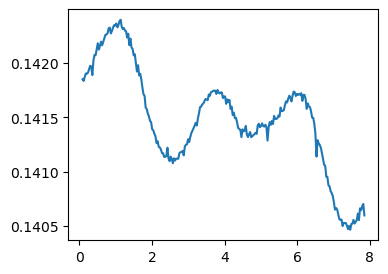

In [124]:
timeavg_df = exp_spectra_df.groupby(['Time_hour_bin'], as_index=False, observed=False).agg(
    Wavelength= ('Wavelength', 'mean'),
    Flux=('Flux', 'mean'), 
    Flux_Error=('Flux_Error', 'mean')
)
print(timeavg_df)

nonnormmodel = LinearRegression()
X2 = timeavg_df.Time_hour_bin.to_numpy().reshape(-1, 1)
nonnormmodel.fit(X2, timeavg_df.Flux)
y2 = nonnormmodel.predict(X2)
# ax+b
regintercept = nonnormmodel.intercept_ 
regslope = nonnormmodel.coef_[0]

print(timeavg_df)
plt.close(), plt.figure(figsize=(4,3))
plt.plot(timeavg_df.Time_hour_bin, timeavg_df.Flux) 
plt.show()

### 2c. And use the detrending to remove linear trend and plot the light curve in each bin

Detrending ON for linear trend


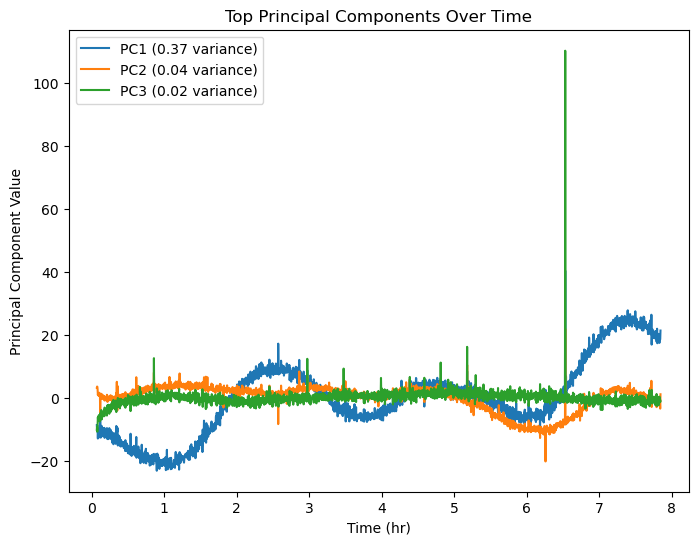

<Figure size 800x600 with 0 Axes>

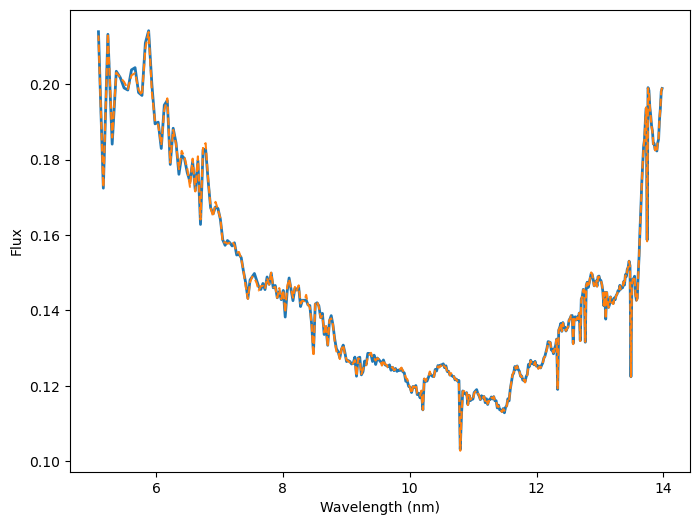

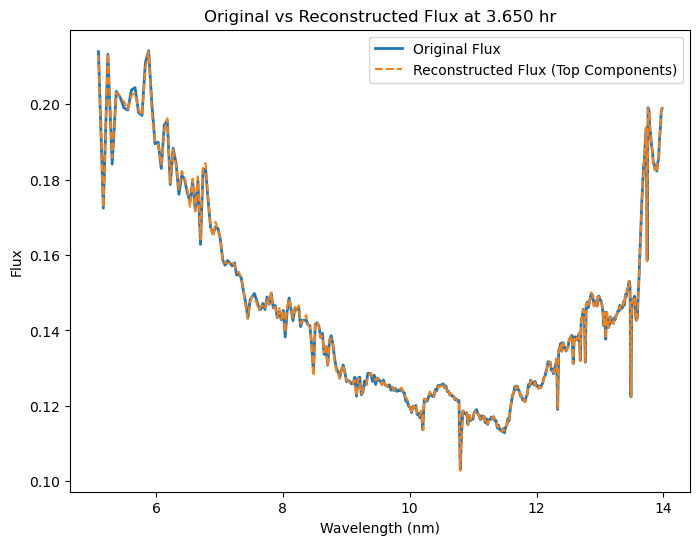

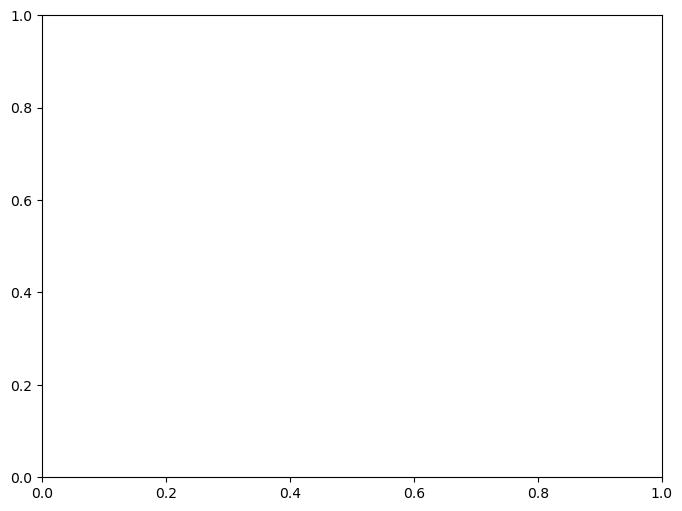

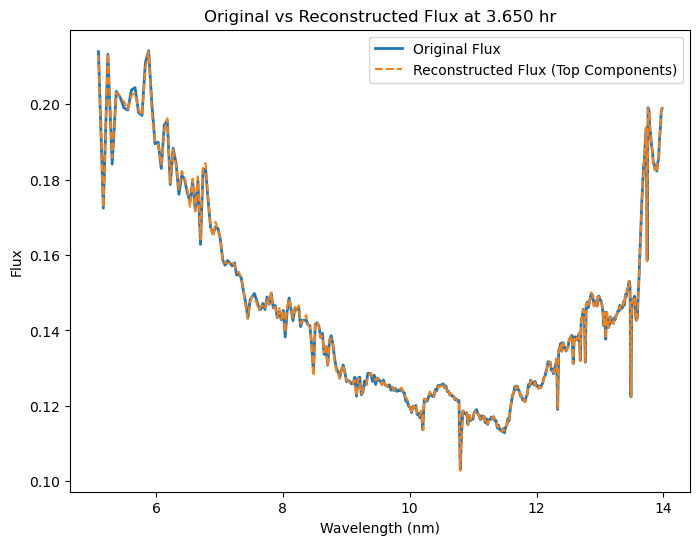

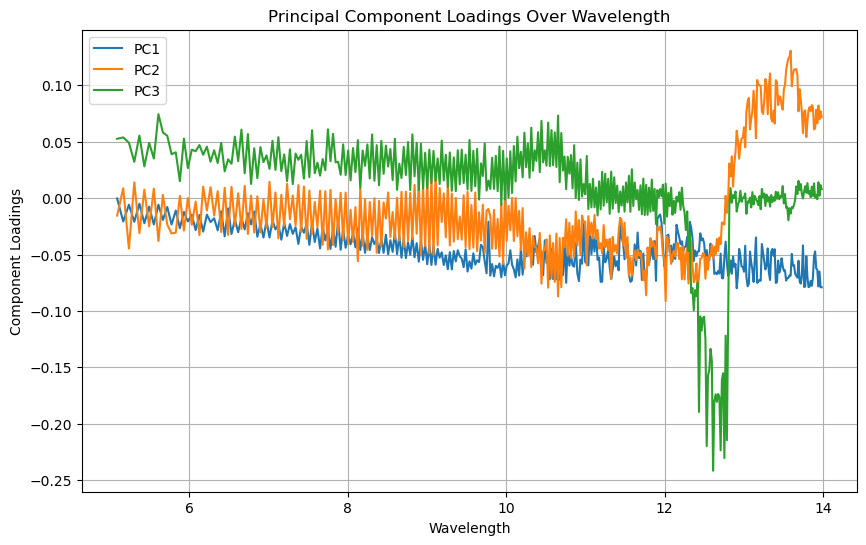

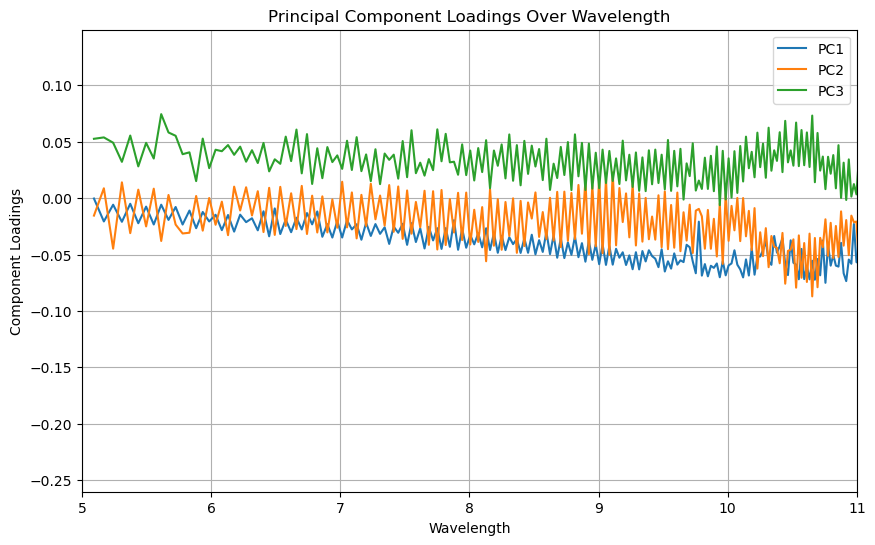

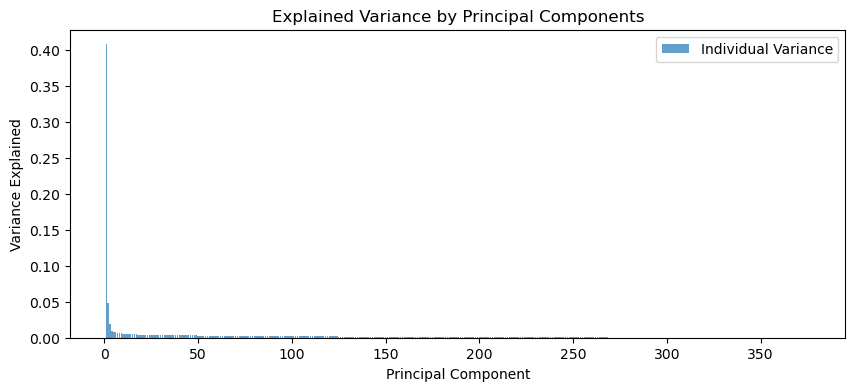

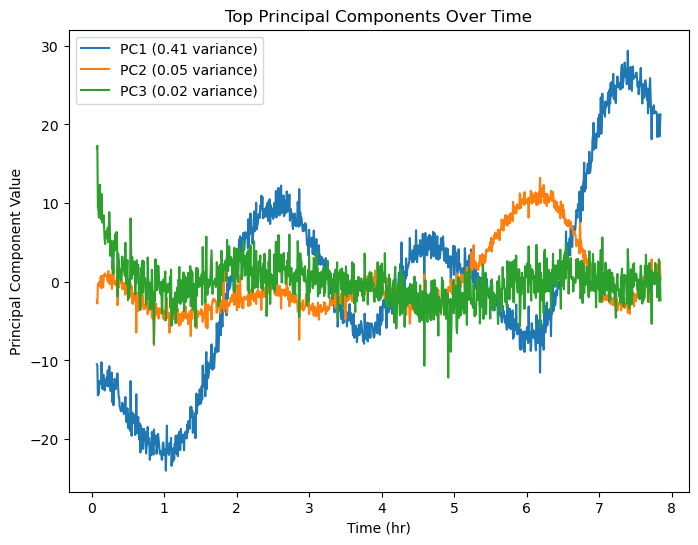

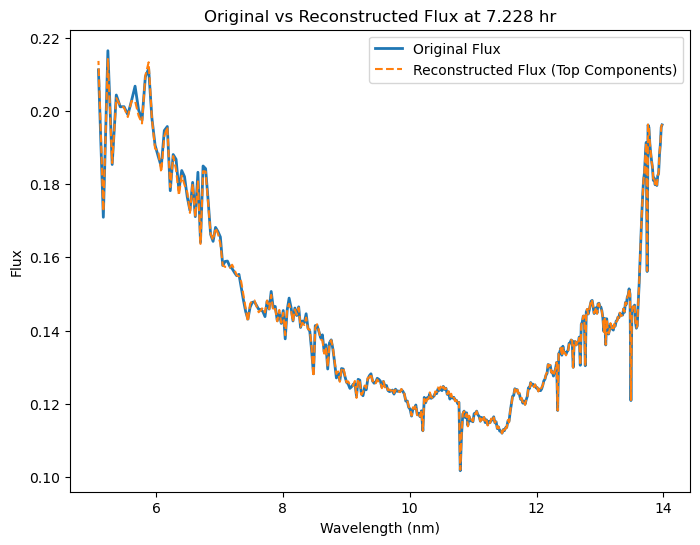

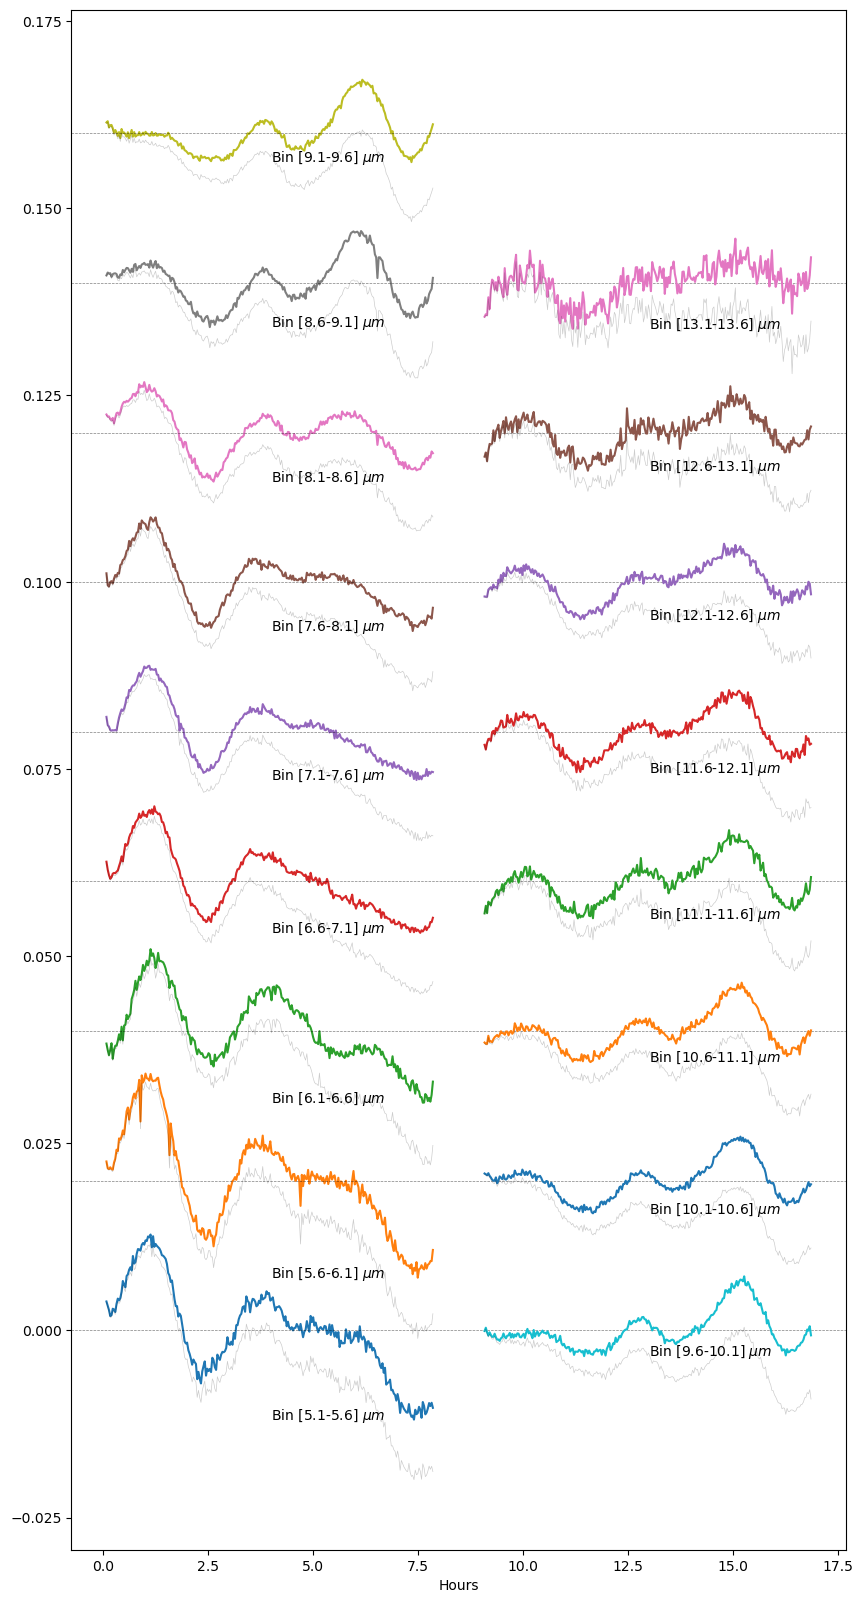

In [159]:
%matplotlib inline
# plot spectra according to the wavelength bins.
plt.close()
fig, ax = plt.subplots(figsize=(10,20))

vspacing = 0
dy = 0.02

################ Detrending options #############
correct_linreg = True
# correct_linreg = False
if correct_linreg:
    print('Detrending ON for linear trend')
else: 
    print('NO Detrending for linear trend')
##############################################

timeavg_mean = timeavg_df.Flux.mean()
coeffs = []
uniq_waves = [value for value in binned_df.Wavelength_bin.unique()]
once = None
norm_df = {}
norm_df = pd.DataFrame(norm_df)

for i, wave in enumerate(uniq_waves):
    flux_vs_time = binned_df.query("Wavelength_bin == @wave", engine='python')
    x = flux_vs_time.Time_hour_bin.to_numpy()
    y0 = flux_vs_time.Median_Flux
    y = (y0 - y0.mean()) / timeavg_mean
    y_uncorrected = (y0 - y0.mean()) / timeavg_mean - modelLinReg_timeavg.intercept_ #+ 0.004

    ### Optional: Apply the flattening:
    if correct_linreg:
        ## linear regression of light curve
        ## Reuse wavelength-wide-level linreg for consistency
        linreg = modelLinReg_timeavg.predict(x.reshape(-1,1))
        y = y - linreg
        # coeffs.append([wave, modelLinReg_timeavg.coef_[0], modelLinReg_timeavg.intercept_])
    # Save normalized flux:
    newarray = []
    newarray = pd.concat([flux_vs_time.Time_hour_bin, 
                         flux_vs_time.Wavelength_bin,
                         y], axis=1)
    norm_df = pd.concat([norm_df, newarray], axis=0)
    
    if i < len(uniq_waves)/2:
        dx = 0
    else: 
        dx=9
        if once == None:
            once = 1
            vspacing = 0
    
    ax.plot(x+dx,y+vspacing)
    ax.plot(x+dx,y_uncorrected+vspacing,c='k', alpha=0.2, lw=0.5)
    ax.axhline(y=y.mean()+vspacing, xmin=0+dx, xmax=8+dx, 
               ls='--', lw=0.5, c='k', alpha=0.5)
    ax.text(4+dx, np.min(y) + vspacing, r'Bin [%.1f-%.1f] $\mu m$'%(wave-0.25, wave+0.25))
    vspacing += dy

ax.set_xlabel('Hours')

# plt.tight_layout()
plt.show()
# print('# Wavebin, Slope, Intercept')
# coeffs = np.array(coeffs)
# print(coeffs)
# print('Std of slopes: ', np.std(coeffs[:,1]))

norm_df = norm_df.rename(columns={'Median_Flux': 'Median_flux_norm_detrended'})
# merged the median_flux and normalized median flux in each bin.
merged_binned_df = pd.merge(binned_df, norm_df, 
                            on=['Time_hour_bin', 'Wavelength_bin'], how='inner')

### 3. Export this cleaned & modified dataset
- Export the expanded spectra: time-cut, wavelength-populated
- Export the wavelength_binned spectra: time-binned (2 min cadence), wave-binned (0.5um resolution), normalized, detrended (optional).

In [160]:
########### Export ################
# export_data = True
export_data = False

# test_detrend = True
test_detrend = False

if 'Wavelength_bin' in exp_spectra_df.columns:
    exp_spectra_df = exp_spectra_df.drop(['Wavelength_bin','Time_hour_bin'], axis=1)
exp_spectra_df['Flux_detrend'] = exp_spectra_df.Flux.mean() + exp_spectra_df.Flux \
                                - (exp_spectra_df.Time_hour * regslope + regintercept)

if test_detrend:
    test = exp_spectra_df.query("5.<Wavelength<5.6")
    print(test)
    plt.close(), plt.figure()
    plt.plot(test.Time_hour.rolling(500).mean(), test.Flux_detrend.rolling(500).mean(), label='detrended')
    plt.plot(test.Time_hour.rolling(500).mean(), test.Flux.rolling(500).mean(), label='original')
    plt.legend()
    plt.show()

## The expanded spectra containing
print(exp_spectra_df.columns, exp_spectra_df.info(),'\n')

## The binned spectra containing
print(merged_binned_df.columns, merged_binned_df.info(), merged_binned_df.head())

if export_data:
    spectraExportName = 'luh16B_cleanData_MIRI_2023jw02965-o001_t001_fluxTimeWave'
    exp_spectra_df.to_hdf(dataOutputFolder+spectraExportName+'.h5', key='df', mode='w')

    binExportName = 'luh16B_cleanData_MIRI_2023jw02965-o001_t001_binnedWave05um_time2min'
    merged_binned_df.to_hdf(dataOutputFolder+binExportName+'.h5', 
                            key='df', mode='w', format='table')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 817048 entries, 0 to 817047
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Time_BJDmid   817048 non-null  float32
 1   Time_hour     817048 non-null  float32
 2   Wavelength    817048 non-null  float32
 3   Flux          817048 non-null  float32
 4   Flux_Error    817048 non-null  float32
 5   Flux_detrend  817048 non-null  float32
dtypes: float32(6)
memory usage: 18.7 MB
Index(['Time_BJDmid', 'Time_hour', 'Wavelength', 'Flux', 'Flux_Error',
       'Flux_detrend'],
      dtype='object') None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4420 entries, 0 to 4419
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   Time_hour_bin               4420 non-null   category
 1   Wavelength_bin              4420 non-null   category
 2   Median_Flux                 44

## 3. Lomb-Scargle Periodograms analysis

### 3a. Plot the periodogram on entire wavelength range:

Generalized LS - statistical output
-----------------------------------
Number of input points:      2173  
Weighted mean of dataset:    0.999988
Weighted rms of dataset:     0.002400
Time base:                   7.772030
Number of frequency points:  20000 

Maximum power p [ZK]:  0.582083
RMS of residuals:      0.001552
  Mean weighted internal error:  0.002000
Best sine frequency:   0.404710 +/-  0.001659
Best sine period:      2.470904 +/-  0.010127
Amplitude:             0.002598 +/-  0.000047
Phase (ph):           -0.188618 +/-  0.002883
Phase (T0):            0.537623 +/-  0.007124
Offset:                1.000073 +/-  0.000033
-----------------------------------


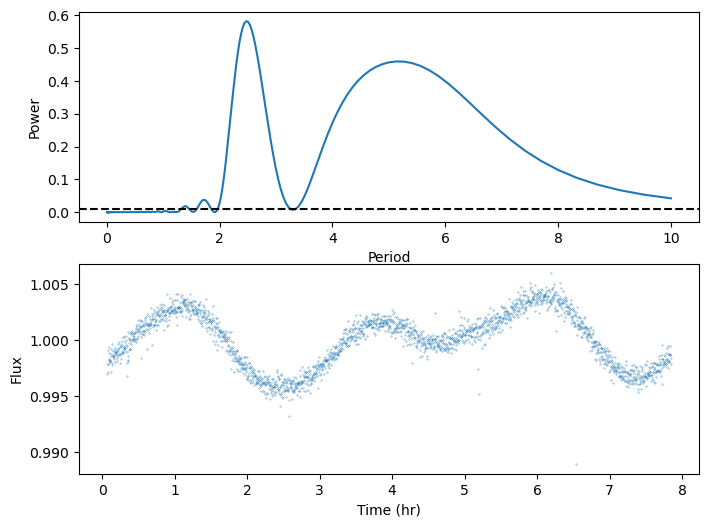

Execution time: dd hh:mm:ss.ss 0 days 00:00:00.825572252


In [161]:
plt.close('all')

# save = True
save = False

t0 = time.time()
# Reused entire-wavelength-range averaged data
timearray = plot_df.Time_hour
yarray = 1+mean_flux_flat
yarray_error = yarray*2e-3

frequen = np.linspace(0.1,100.,20000)

# Compute the GLS periodogram with default options.
# Choose Zechmeister-Kuerster normalization explicitly
clp = pyPeriod.Gls((timearray,yarray,yarray_error), norm="ZK", freq=frequen,ofac=10)

frequencies = clp.freq
power = clp.power
periods = 1./frequencies

# Print helpful information to screen
clp.info()

# Define FAP levels (fraction)
fapLevels = 0.1
# Obtain the associated power thresholds
plevels = clp.powerLevel(fapLevels)
t1 = time.time()

## Plotting the periodograms
fig, (ax,ax2) = plt.subplots(2,1, figsize=(8,6))
ax.plot(periods, power, label='Periodogram')
ax.set_ylabel('Power')
ax.set_xlabel('Period')
ax.axhline(y=plevels, xmin=0, xmax=10, ls='--', c='k', label='10\% FAP')

ax2.plot(timearray, yarray, ls='', marker='.', ms=0.5, label='Wave-avg. MIRI Luhman 16 B')
ax2.set_ylabel('Flux')
ax2.set_xlabel('Time (hr)')

plt.show()
printtime(t0,t1)

### 3b. plot the periodogram for each wavelength bin of 0.5um

No output of frequency error.
Increase frequency range to sample the peak maximum.
No output of frequency error.
Increase frequency range to sample the peak maximum.
No output of frequency error.
Increase frequency range to sample the peak maximum.
No output of frequency error.
Increase frequency range to sample the peak maximum.
No output of frequency error.
Increase frequency range to sample the peak maximum.
No output of frequency error.
Increase frequency range to sample the peak maximum.
No output of frequency error.
Increase frequency range to sample the peak maximum.
No output of frequency error.
Increase frequency range to sample the peak maximum.
No output of frequency error.
Increase frequency range to sample the peak maximum.
No output of frequency error.
Increase frequency range to sample the peak maximum.
No output of frequency error.
Increase frequency range to sample the peak maximum.
No output of frequency error.
Increase frequency range to sample the peak maximum.
No o

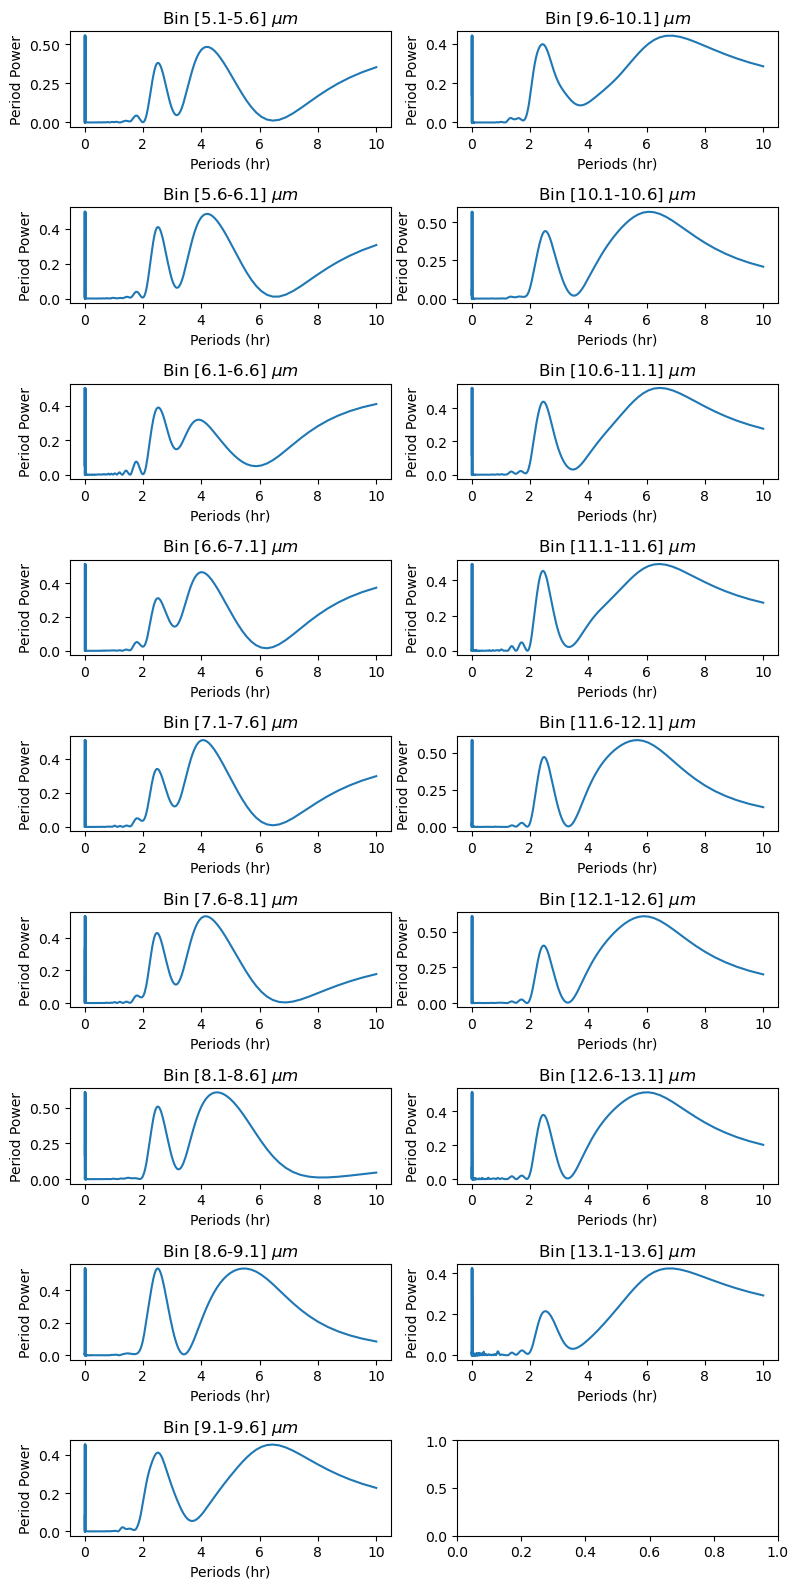

Execution time: dd hh:mm:ss.ss 0 days 00:00:03.997406959


In [162]:
%matplotlib inline
# plot periodogram according to the wavelength bins.
plt.close()
fig, axs = plt.subplots(9,2,figsize=(8,16))

vspacing = 0
dy = 1

uniq_waves = [value for value in merged_binned_df.Wavelength_bin.unique()]
once = None

t0 = time.time()

# Regular code where warnings are shown# Suppress specific warnings
# warnings.filterwarnings("ignore", message=".*Highest peak is at the edge of the frequency range.*")

for i, wave in enumerate(uniq_waves):
    flux_vs_time = merged_binned_df.query("Wavelength_bin == @wave", engine='python')[['Time_hour_bin', 'Median_flux_norm_detrended']]
    x = flux_vs_time.Time_hour_bin.to_numpy()
    y = 1+flux_vs_time.Median_flux_norm_detrended.to_numpy()
    
    frequen = np.linspace(0.1,100.,20000)
    # Compute the GLS periodogram with default options. Choose Zechmeister-Kuerster normalization explicitly
    clp = pyPeriod.Gls((x,y,y*2e-3), norm="ZK", freq=frequen,ofac=10)
    
    frequencies = clp.freq
    power = clp.power
    periods = 1./frequencies
    
    # # Define FAP levels (fraction)
    # fapLevels = 0.1
    # # Obtain the associated power thresholds
    # plevels = clp.powerLevel(fapLevels)
    
    if i < len(uniq_waves)/2:
        col=0
        row=i
    else: 
        row=i%int(ceil(17/2)) 
        col=1 
        if once == None:
            once = 1
            vspacing = 0
    
    axs[row,col].plot(periods,power)
    axs[row,col].set_title(r'Bin [%.1f-%.1f] $\mu m$'%(wave-0.25, wave+0.25))
    axs[row,col].set_xlabel('Periods (hr)')
    axs[row,col].set_ylabel('Period Power')
t1 = time.time()
# ax.set_xlabel('Hours')
# ax.set_ylabel('Period Power')

plt.tight_layout()
plt.show()
printtime(t0, t1)

## 4. Principle Component Analysis

### 4a. Initialize + apply to detrended data

In [164]:
# Pivot the dataframe: into 2D table
# Time as index, Wavelength as columns, Flux_detrended as values

# ============= mean spectrum subtract ===============
# If the main variation in your data is a dominant mean flux across all wavelengths, 
# PCA may not capture deviations effectively.
# Solution: Subtract the mean spectrum (average flux across time) before applying PCA.

if correct_linreg:
    fluxColumn='Flux_detrend'
else:
    fluxColumn='Flux'

pca_df = exp_spectra_df.pivot(index='Time_hour', columns='Wavelength', values=fluxColumn)
# Optional: Reset the column names for clarity
pca_df.columns = [f"λ__{w:.3f}" for w in pca_df.columns]  # Add λ prefix for wavelengths

# Reduce time resolution by 2
pca_df = pca_df[::2]
# Print the reshaped DataFrame
print(pca_df)

           λ__5.093  λ__5.170  λ__5.242  λ__5.310  λ__5.374  λ__5.437  \
Time_hour                                                               
0.071566   0.198541  0.197170  0.193203  0.189673  0.185516  0.184527   
0.078722   0.198774  0.197174  0.192874  0.189550  0.185584  0.184241   
0.085879   0.198621  0.197320  0.193286  0.189985  0.185652  0.184296   
0.093035   0.198455  0.197279  0.193116  0.189810  0.185254  0.184368   
0.100192   0.198611  0.197274  0.193355  0.189820  0.185130  0.184339   
...             ...       ...       ...       ...       ...       ...   
7.814969   0.196869  0.196032  0.191312  0.188680  0.183223  0.182679   
7.822126   0.196668  0.196287  0.191737  0.188961  0.183530  0.182570   
7.829282   0.196520  0.195954  0.191281  0.188853  0.183922  0.182909   
7.836439   0.196738  0.196122  0.191725  0.189038  0.183479  0.182601   
7.843596   0.196691  0.196283  0.191643  0.189123  0.183470  0.182531   

           λ__5.497  λ__5.556  λ__5.614  λ__5.670 

In [194]:
# Standardize the data: Zero mean and unit variance
# sub_mean = True # subtract the mean-spec from the total flux
sub_mean = False

scaler = StandardScaler()
flux_centered_wave = pca_df.sub(pca_df.mean(axis=0), axis=1)
if sub_mean:
    flux_scaled = scaler.fit_transform(flux_centered_wave)
else:
    flux_scaled = scaler.fit_transform(pca_df)

# Note: Standardizing ensures that PCA focuses on variance rather than magnitude.

# Perform PCA
pca = PCA()
flux_pca = pca.fit_transform(flux_scaled)  # Transform the data into principal components

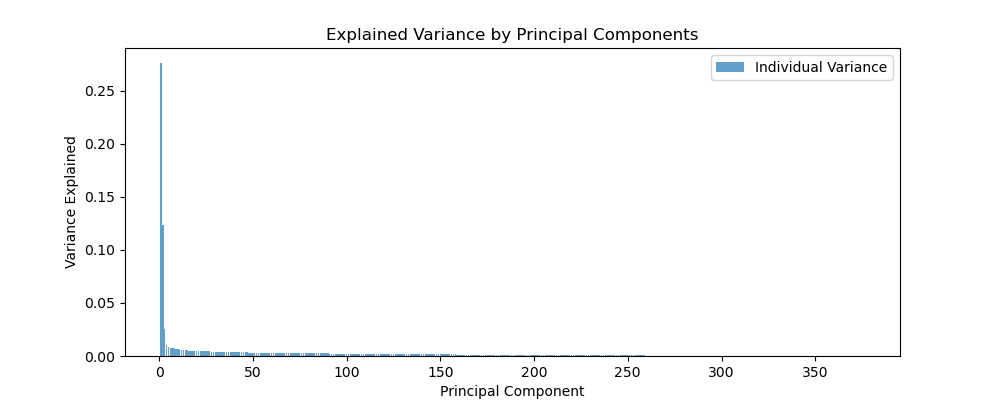

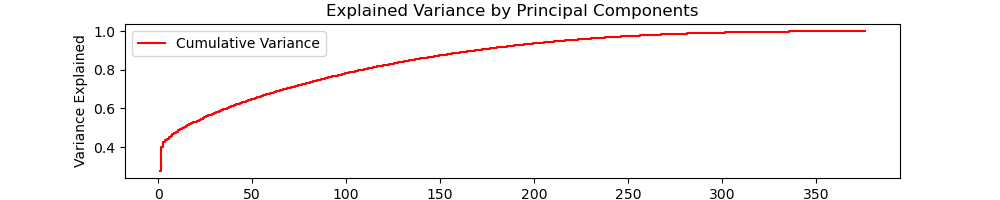

In [195]:
# Plot Explained Variance Ratio to Understand Component Importance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(10, 4))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.7, label='Individual Variance')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.title('Explained Variance by Principal Components')
plt.legend()
plt.show()

plt.figure(figsize=(10, 2))
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', color='red', label='Cumulative Variance')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.title('Explained Variance by Principal Components')
plt.legend()
plt.show()

# Practical Insight:
# - Look for the "elbow" point: the number of components that explain most of the variance.
# ---> Elbow point: ~ component 5th
# - Choose components before the cumulative variance plateaus (e.g., 90%-95%).

In [196]:
# Inspect Principal Components
n_components_to_keep = 5  # Adjust based on the elbow point
pca = PCA(n_components=n_components_to_keep)
flux_pca_reduced = pca.fit_transform(flux_scaled)

print(f"Shape of reduced PCA data (time, components): {flux_pca_reduced.shape}")
print("Explained Variance Ratio (Top Components):", pca.explained_variance_ratio_)

# ================ Output: ================================ 
# Shape of reduced PCA data (time, components): (2173, 3)
# Explained Variance Ratio (Top Components): [..   ..   ..]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


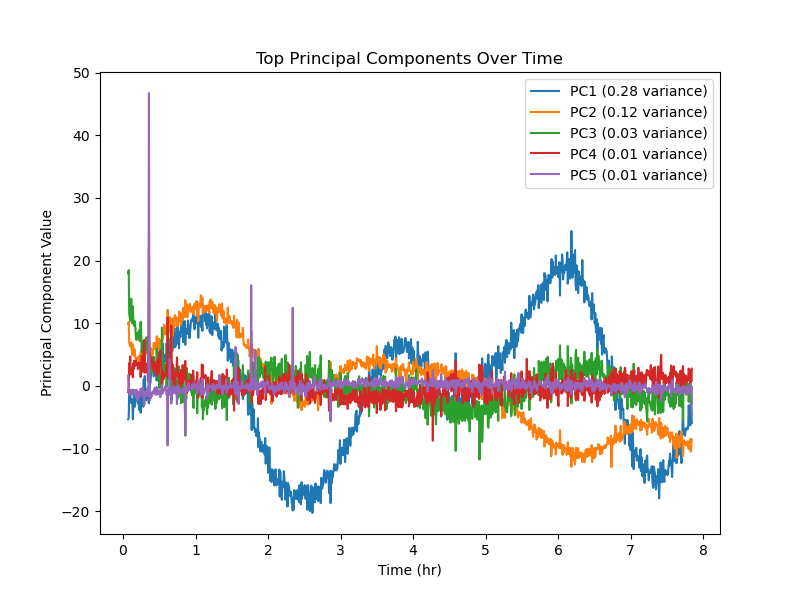

In [197]:
%matplotlib widget
# Plot the top principal components as a function of time
time_plot = pca_df.index.values

plt.close()
plt.figure(figsize=(8, 6))
for i in range(n_components_to_keep):
    plt.plot(time_plot, flux_pca_reduced[:, i], label=f'PC{i+1} ({explained_variance_ratio[i]:.2f} variance)')
plt.xlabel('Time (hr)')
plt.ylabel('Principal Component Value')
plt.title('Top Principal Components Over Time')
plt.legend()
plt.show()

# Practical Insight:
# - PC1 (first principal component): Represents the largest trend in the data.
# - PC2, PC3: Capture additional features (e.g., periodic or localized changes in flux).

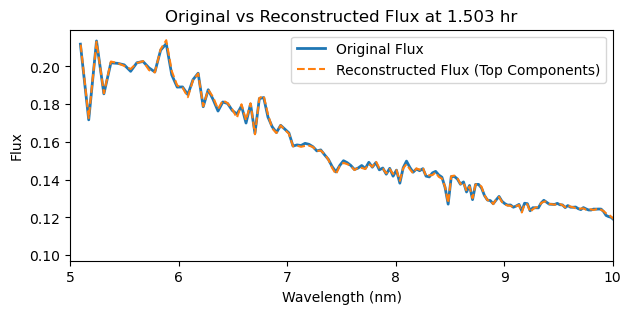

In [208]:
%matplotlib inline
plt.close('all')
# Project the reduced data back to the original space
flux_reconstructed = pca.inverse_transform(flux_pca_reduced)
flux_reconstructed = scaler.inverse_transform(flux_reconstructed)

# Compare Original vs Reconstructed Data at time tc = 1000
for tindx in [200]:
    wave_plot = exp_spectra_df.Wavelength.unique()
    
    plt.figure(figsize=(7, 3))
    plt.plot(wave_plot, pca_df.iloc[tindx], label='Original Flux', linewidth=2)
    plt.plot(wave_plot, flux_reconstructed[tindx, :], label='Reconstructed Flux (Top Components)', linestyle='--')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Flux')
    plt.title('Original vs Reconstructed Flux at %.3f hr'%time_plot[tindx])
    plt.legend()
    plt.xlim(5,10)
    plt.show()

# Practical Insight:
# - Reconstruction helps visualize how much information is preserved.
# - If the reconstructed flux is close to the original, the chosen PCs effectively summarize the data.


## 4b. loading plots: PCA loadings (or eigenvectors) 
Represent how much each original variable (wavelength in this case) contributes to a principal component

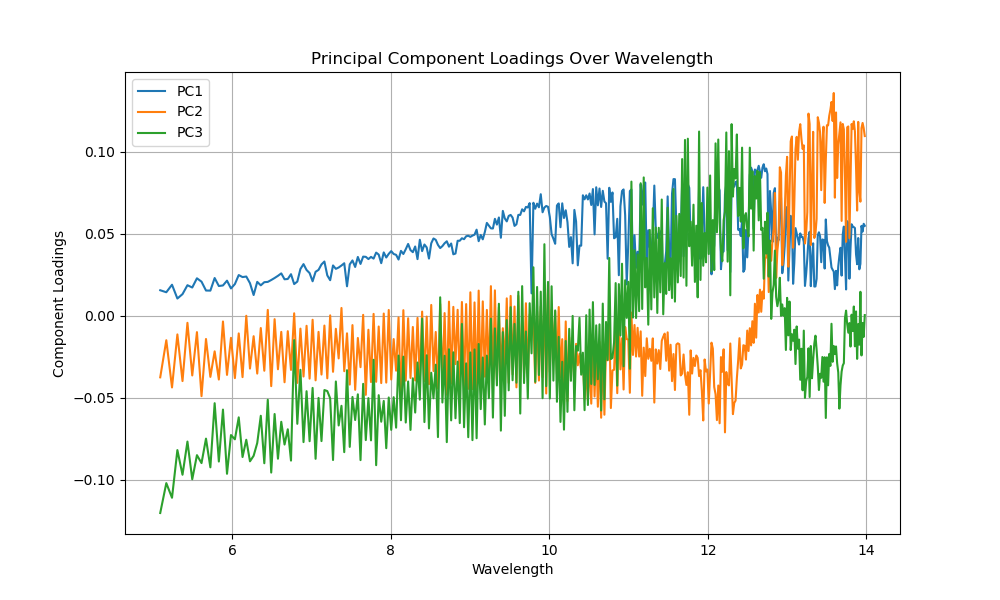

(5.0, 10.0)

In [193]:
# Access the PCA loadings (eigenvectors)
loadings = pca.components_  # Shape: (n_components, n_features)

# Plot the loadings for each principal component
plt.figure(figsize=(10, 6))
for i in range(n_components_to_keep):
    plt.plot(wave_plot, loadings[i, :], label=f'PC{i+1}')

plt.xlabel('Wavelength')
plt.ylabel('Component Loadings')
plt.title('Principal Component Loadings Over Wavelength')
plt.legend()
plt.grid()
plt.show()
plt.xlim(5,10)
